# 04 – QA Prioritization & CI Risk Gate Demo

This notebook shows how to:
- Take the **CatBoost classifier** output (risk_score).
- Combine it with **code_churn_score** using historical bounds.
- Produce a **QA_priority_score** and bucket (Critical / High / Medium / Low).
- Export a CSV for **Tableau / dashboards**.
- Demonstrate how this ties into the `risk_gate.py` CI script.

In [5]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# 1. Correct Project and Data Paths
# Set PROJECT_ROOT to the PARENT of the current notebook directory
PROJECT_ROOT = Path.cwd().parent 
DATA_DIR = PROJECT_ROOT / "data"

print("Project root (Corrected):", PROJECT_ROOT)
print("Data dir (Corrected)  :", DATA_DIR)

# 2. Correct Scored File Path
# The scored file (output of risk_gate.py) is in the Project Root.
# It is named "scored_" + the input file name.
scored_file = PROJECT_ROOT / "scored_test_patch_features.csv"

if not scored_file.exists():
    raise FileNotFoundError(
        f"Expected scored file not found at {scored_file.resolve()}. \n"
        f"Please ensure you run 'python risk_gate.py data/test_patch_features.csv' from the project root first."
    )

# Load the file
scored_df = pd.read_csv(scored_file)
print("\n✅ Scored file loaded successfully.")
print("Scored columns:", scored_df.columns.tolist())
print("First rows:\n", scored_df.head(), "\n")

Project root (Corrected): /Users/hc/Documents/projects/roku-patch-stability-analytics
Data dir (Corrected)  : /Users/hc/Documents/projects/roku-patch-stability-analytics/data

✅ Scored file loaded successfully.
Scored columns: ['firmware_version', 'code_churn_score', 'previous_version_error_rate', 'avg_device_age_days', 'is_hotfix', 'patch_security', 'risk_score', 'high_risk_flag']
First rows:
   firmware_version  code_churn_score  previous_version_error_rate  avg_device_age_days  is_hotfix  patch_security  \
0           10.0.1          0.279867                     0.000000           702.219142      False           False   
1           10.0.2          0.292176                   452.759060           426.954965      False           False   
2           10.0.3          0.214577                  2133.975495           336.319311      False           False   
3           10.0.4          0.172038                  3624.725127           340.087869      False           False   
4           10.1.

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

In [13]:
# Historical churn bounds from training data (Notebook 03)
CHURN_HISTORICAL_MIN = 0.14
CHURN_HISTORICAL_MAX = 0.87

if CHURN_HISTORICAL_MAX <= CHURN_HISTORICAL_MIN:
    raise ValueError("Historical churn max must be > min. Check the values.")

# Weights for composite QA priority score
# Can be tuned later – these are reasonable starting values.
W_MODEL = 0.6   # weight on CatBoost risk_score
W_CHURN = 0.4   # weight on normalized code_churn_score

# --- NEW: Define Bucketing Thresholds as Constants ---
CRITICAL_THRESHOLD = 0.85
HIGH_THRESHOLD = 0.65
MEDIUM_THRESHOLD = 0.40 # Implicit Low is below this

print("Historical churn min:", CHURN_HISTORICAL_MIN)
print("Historical churn max:", CHURN_HISTORICAL_MAX)
print("Weights -> model:", W_MODEL, "| churn:", W_CHURN)

Historical churn min: 0.14
Historical churn max: 0.87
Weights -> model: 0.6 | churn: 0.4


In [12]:
# Ensure required columns exist
required_cols = ["firmware_version", "code_churn_score", "risk_score"]
missing = [c for c in required_cols if c not in scored_df.columns]
if missing:
    raise ValueError(f"Missing required columns in scored_df: {missing}")

# 1) Normalize churn using training-set bounds
scored_df["churn_norm"] = (
    (scored_df["code_churn_score"] - CHURN_HISTORICAL_MIN)
    / (CHURN_HISTORICAL_MAX - CHURN_HISTORICAL_MIN + 1e-6)
)

# Clamp to [0, 1] in case a patch lands just outside the historical extremes
scored_df["churn_norm"] = scored_df["churn_norm"].clip(0.0, 1.0)

# 2) Composite priority score
scored_df["QA_priority_score"] = (
    W_MODEL * scored_df["risk_score"]
    + W_CHURN * scored_df["churn_norm"]
)

scored_df[["firmware_version", "code_churn_score", "churn_norm", "risk_score", "QA_priority_score"]].head()

,firmware_version,code_churn_score,churn_norm,risk_score,QA_priority_score
0,10.0.1,0.279867,0.191598,0.016229,0.086377
1,10.0.2,0.292176,0.208461,0.005618,0.086755
2,10.0.3,0.214577,0.102160,0.006206,0.044588
3,10.0.4,0.172038,0.043888,0.620677,0.389962
4,10.1.0,0.240462,0.137618,0.201233,0.175787


In [14]:
def bucket_priority(score: float) -> str:
    """Map composite score to a qualitative bucket."""
    # Use constants instead of hardcoded numbers
    if score >= CRITICAL_THRESHOLD:
        return "Critical"
    elif score >= HIGH_THRESHOLD:
        return "High"
    elif score >= MEDIUM_THRESHOLD:
        return "Medium"
    else:
        return "Low"
        
scored_df["QA_bucket"] = scored_df["QA_priority_score"].apply(bucket_priority)

# Quick sanity check
scored_df[["firmware_version", "QA_priority_score", "QA_bucket"]].head(10)

,firmware_version,QA_priority_score,QA_bucket
0,10.0.1,0.086377,Low
1,10.0.2,0.086755,Low
2,10.0.3,0.044588,Low
3,10.0.4,0.389962,Low
4,10.1.0,0.175787,Low
5,10.2.0,0.821120,High
6,10.3.0,0.041886,Low
7,10.4.0,0.697950,High
8,10.4.1,0.577457,Medium
9,10.4.2,0.287863,Low


In [9]:
qa_cols = [
    "firmware_version",
    "code_churn_score",
    "churn_norm",
    "risk_score",
    "high_risk_flag",
    "QA_priority_score",
    "QA_bucket",
]

qa_priority_path = DATA_DIR / "firmware_qa_priority.csv"
qa_priority_path.parent.mkdir(parents=True, exist_ok=True)

scored_df[qa_cols].to_csv(qa_priority_path, index=False)

print(f"✅ QA prioritization sheet saved to: {qa_priority_path}")
scored_df[qa_cols].sort_values("QA_priority_score", ascending=False).head(10)

✅ QA prioritization sheet saved to: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/firmware_qa_priority.csv


,firmware_version,code_churn_score,churn_norm,risk_score,high_risk_flag,QA_priority_score,QA_bucket
14,10.5.4,0.684074,0.745306,0.972605,1,0.881685,Critical
5,10.2.0,0.585893,0.610811,0.961326,1,0.821120,High
47,10.10.0,0.451159,0.426245,0.968586,1,0.751650,High
11,10.5.1,0.385759,0.336655,0.977943,1,0.721428,High
7,10.4.0,0.340778,0.275038,0.979892,1,0.697950,High
36,10.7.5,0.242240,0.140055,0.979955,1,0.643995,Medium
10,10.5.0,0.265577,0.172023,0.930101,1,0.626870,Medium
49,10.10.2,0.205481,0.089701,0.961969,1,0.613062,Medium
42,10.7.11,0.143966,0.005433,0.970958,1,0.584748,Medium
8,10.4.1,0.199140,0.081014,0.908419,1,0.577457,Medium


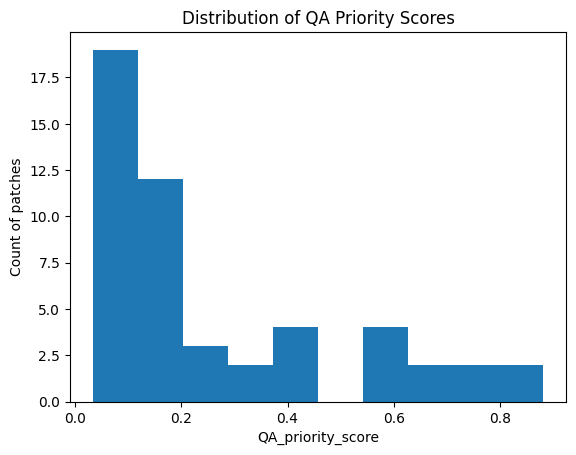

QA_bucket
Low         38
Medium       7
High         4
Critical     1
Name: count, dtype: int64

In [10]:
import matplotlib.pyplot as plt

plt.hist(scored_df["QA_priority_score"], bins=10)
plt.xlabel("QA_priority_score")
plt.ylabel("Count of patches")
plt.title("Distribution of QA Priority Scores")
plt.show()

scored_df["QA_bucket"].value_counts()

## CI Gate + QA Prioritization Summary

- `risk_gate.py` runs in CI and:
  - Loads the input patch feature file.
  - Uses the saved CatBoost classifier to compute `risk_score`.
  - Writes `scored_*.csv`.
  - Fails CI if any `high_risk_flag == 1`.

- This notebook:
  - Takes the `scored_*.csv` file.
  - Normalizes `code_churn_score` using historical training bounds.
  - Builds `QA_priority_score` from `risk_score` + churn.
  - Buckets patches into `Critical / High / Medium / Low`.
  - Outputs `firmware_qa_priority.csv` for Tableau and exec review.